### 3D classification
Notebook to train a DenseNet based classifier to identify TED images from normal on Orbital CT images

## Setup environment

In [4]:
!pip install -q "monai[nibabel,tqdm]"

import monai

## Setup imports

In [5]:
import logging
import os
import sys
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np

import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, ImageDataset
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    RandRotate90,
    Resize,
    ScaleIntensity,
    DivisiblePadd,
)

pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
print_config()

MONAI version: 1.3.0
Numpy version: 1.23.5
Pytorch version: 2.1.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.11.4
Pillow version: 9.4.0
Tensorboard version: 2.15.1
gdown version: 4.6.6
TorchVision version: 0.16.0+cu121
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.35.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
   

In [6]:
from google.colab import drive
drive.mount('/content/drive')

import os
print(os.getcwd())

os.chdir('/content/drive/MyDrive/05_eom_classification/02_training/202311')
print(os.getcwd())

Mounted at /content/drive
/content
/content/drive/MyDrive/05_eom_classification/02_training/202311


In [7]:

import glob
import random

'''

1. Loads the datasets and preprocessing steps
2. Builds train and validation dataset
3. Defines the 3D model
4. Trains the model

This runs on the 02_training folder
Data folder is '../01_data/nifti_format'

'''


#--------------------------  1 - LOAD DATASET ----------------------------
data_dir = '/content/drive/MyDrive/05_eom_classification/01_data/nifti_format'

normal_scan_paths = glob.glob(os.path.join(data_dir, 'normal_scans/*'))
abnormal_scan_paths = glob.glob(os.path.join(data_dir, 'ted_scans/*'))


print("CT scans with normal orbits: " + str(len(normal_scan_paths)))
print("CT scans with TED orbits: " + str(len(abnormal_scan_paths)))


CT scans with normal orbits: 378
CT scans with TED orbits: 70


In [8]:

#run = 'trial'
run = 'full'

#--------------------------  2 - DEFINE TRAIN & HOLDOUT SETS ----------------------------


all_scan_paths = normal_scan_paths + abnormal_scan_paths
#print(all_scan_paths)
print(len(all_scan_paths))

print(all_scan_paths[0])
patient_ids = np.unique([scan_path.split("/")[-1].split("_")[0] for scan_path in all_scan_paths])
print(patient_ids)
print(len(patient_ids))


# Split patient_ids into train (which has the train and validation set) and test (hold-out set) for training and evaluation purposes
random.seed(42)
random.shuffle(patient_ids)
train_patient_ids = patient_ids[:int(0.8*len(patient_ids))]
test_patient_ids = patient_ids[int(0.8*len(patient_ids)):]

normal_scan_paths_train = [scan_path for scan_path in normal_scan_paths if scan_path.split("/")[-1].split("_")[0] in train_patient_ids]
normal_scan_paths_test = [scan_path for scan_path in normal_scan_paths if scan_path.split("/")[-1].split("_")[0] in test_patient_ids]

abnormal_scan_paths_train = [scan_path for scan_path in abnormal_scan_paths if scan_path.split("/")[-1].split("_")[0] in train_patient_ids]
abnormal_scan_paths_test = [scan_path for scan_path in abnormal_scan_paths if scan_path.split("/")[-1].split("_")[0] in test_patient_ids]

print(len(normal_scan_paths_train))
print(len(normal_scan_paths_test))
print(len(abnormal_scan_paths_train))
print(len(abnormal_scan_paths_test))



if run == 'trial':

    normal_scan_paths_train  = normal_scan_paths_train[0:5]
    normal_scan_paths_test = normal_scan_paths_test[0:5]
    abnormal_scan_paths_train = abnormal_scan_paths_train[0:5]
    abnormal_scan_paths_test = abnormal_scan_paths_test[0:5]



448
/content/drive/MyDrive/05_eom_classification/01_data/nifti_format/normal_scans/1240609_273592738_2_NORMAL.nii.gz
['1105223' '1240609' '1333783' '1500474' '1634475' '1743421' '1743536'
 '1795072' '1903360' '1912285' '2007785' '2047857' '2083136' '2229425'
 '2266400' '2349789' '2368190' '2409108' '2425900' '2498999' '2500040'
 '2566101' '2583444' '2623135' '2730970' '2949018' '3111311' '3156002'
 '3309989' '3362470' '3484508' '3491113' '3634060' '3768947' '3786939'
 '3818818' '3864273' '3913671' '3924265' '3976252' '3986158' '4069876'
 '4140866' '4192210' '4201834' '4217380' '4232883' '4267931' '4395339'
 '4409588' '4470387' '4558925' '4580209' '4645919' '4680458' '4727583'
 '4741195' '4764750' '4808685' '4816283' '4912188' '4955673' '4978872'
 '4983805' '4992872' '4994556' '4995233' '4999773' '5010751' '5037823'
 '5051411' '5065023' '5066839' '5081377' '5093088' '5107039' '5112968'
 '5280372' '5285150' '5296487' '5302603' '5324675' '5327626' '5350286'
 '5359166' '5365342' '5372308' 

In [9]:
images= normal_scan_paths_train + abnormal_scan_paths_train
random.seed(42)
random.shuffle(images)
labels = np.array([1 if 'TED' in scan_path else 0 for scan_path in images])
print("Total images in training set: "+str(len(images)))
print("TED vs normal labels: "+str(labels))
# Represent labels in one-hot format for binary classifier training,
# BCEWithLogitsLoss requires target to have same shape as input
labels = torch.nn.functional.one_hot(torch.as_tensor(labels)).float()

Total images in training set: 346
TED vs normal labels: [0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 1]


In [10]:
## Training and validation (cross-validation not done)

img_sz = 128

# Define transforms
train_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), Resize((img_sz, img_sz, img_sz)), RandRotate90()])
val_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), Resize((img_sz, img_sz, img_sz))])


# Define nifti dataset, data loader
check_ds = ImageDataset(image_files=images, labels=labels, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=3, num_workers=2, pin_memory=pin_memory)

im, label = monai.utils.misc.first(check_loader)
print(type(im), im.shape, label, label.shape)

# create a training data loader
train_ds = ImageDataset(image_files=images[:int(len(images)*0.8)], labels=labels[:int(len(images)*0.8)], transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2, pin_memory=pin_memory)

# create a validation data loader
val_ds = ImageDataset(image_files=images[int(len(images)*0.8)+1:], labels=labels[int(len(images)*0.8)+1:], transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=20, num_workers=2, pin_memory=pin_memory)


<class 'monai.data.meta_tensor.MetaTensor'> torch.Size([3, 1, 128, 128, 128]) tensor([[1., 0.],
        [1., 0.],
        [1., 0.]]) torch.Size([3, 2])


In [12]:
##### TRAINING ##########

# Create DenseNet121, CrossEntropyLoss and Adam optimizer
#model = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=1, out_channels=2).to(device)
model = monai.networks.nets.DenseNet264(spatial_dims=3, in_channels=1, out_channels=2).to(device)

# loss_function = torch.nn.CrossEntropyLoss()
loss_function = torch.nn.BCEWithLogitsLoss()  # also works with this data

optimizer = torch.optim.Adam(model.parameters(), 1e-4)

# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
max_epochs = 20

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()

        num_correct = 0.0
        metric_count = 0
        for val_data in val_loader:
            val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
            with torch.no_grad():
                val_outputs = model(val_images)
                value = torch.eq(val_outputs.argmax(dim=1), val_labels.argmax(dim=1))
                metric_count += len(value)
                num_correct += value.sum().item()

        metric = num_correct / metric_count
        metric_values.append(metric)

        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), "best_metric_model_classification3d_array.pth")
            print("saved new best metric model")

        print(f"Current epoch: {epoch+1} current accuracy: {metric:.4f} ")
        print(f"Best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}")
        writer.add_scalar("val_accuracy", metric, epoch + 1)

print(f"Training completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/20
1/138, train_loss: 0.6684
2/138, train_loss: 0.6826
3/138, train_loss: 0.6646
4/138, train_loss: 0.5926
5/138, train_loss: 0.5667
6/138, train_loss: 0.5982
7/138, train_loss: 0.9803
8/138, train_loss: 0.4804
9/138, train_loss: 0.4545
10/138, train_loss: 0.4369
11/138, train_loss: 0.8187
12/138, train_loss: 0.3827
13/138, train_loss: 0.3634
14/138, train_loss: 0.6888
15/138, train_loss: 0.3298
16/138, train_loss: 0.3306
17/138, train_loss: 0.3170
18/138, train_loss: 0.5187
19/138, train_loss: 0.2663
20/138, train_loss: 0.2881
21/138, train_loss: 0.2720
22/138, train_loss: 0.2472
23/138, train_loss: 0.2160
24/138, train_loss: 1.0971
25/138, train_loss: 0.8481
26/138, train_loss: 1.0709
27/138, train_loss: 0.1865
28/138, train_loss: 0.6578
29/138, train_loss: 0.1959
30/138, train_loss: 0.2389
31/138, train_loss: 0.6542
32/138, train_loss: 0.2476
33/138, train_loss: 0.7423
34/138, train_loss: 0.2545
35/138, train_loss: 0.1968
36/138, train_loss: 0.1771
37/138, train_l

In [14]:
##### TESTING ##########

# Create DenseNet121, CrossEntropyLoss and Adam optimizer
#model = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=1, out_channels=2).to(device)
model = monai.networks.nets.DenseNet264(spatial_dims=3, in_channels=1, out_channels=2).to(device)
dst = 'best_metric_model_classification3d_array.pth'
model.load_state_dict(torch.load(dst))


<All keys matched successfully>

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, accuracy_score


test_images = normal_scan_paths_test + abnormal_scan_paths_test
random.seed(42)
random.shuffle(test_images)
test_labels = np.array([1 if 'TED' in scan_path else 0 for scan_path in test_images])
print("No. of images in test set:" + str(len(test_images)))
print("Test image ground truth labels: "+str(test_labels))
# Represent labels in one-hot format for binary classifier training,
# BCEWithLogitsLoss requires target to have same shape as input

test_labels = torch.nn.functional.one_hot(torch.as_tensor(test_labels)).float()

# Test transforms same as validation transforms
test_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), Resize((img_sz, img_sz, img_sz))])
# create a test data loader
test_ds = ImageDataset(image_files=test_images, labels=test_labels, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=2, pin_memory=pin_memory)

model.eval()

y_pred_results = []
y_true_results = []

for val_data in test_loader:

    val_images, val_labels = val_data[0].to(device), val_data[1].to(device)

    with torch.no_grad():
        val_outputs = model(val_images)
        value = torch.eq(val_outputs.argmax(dim=1), val_labels.argmax(dim=1))

    y_true = [True if val_labels[i][0]==1 else False for i in range(len(value))]
    y_pred = value.detach().cpu().numpy()
    y_true_results.append(y_true[0])
    y_pred_results.append(y_pred[0])

print("Ground truth labels: "+str(y_true_results))
print("Predicted labels: "+str(y_pred_results))

No. of images in test set:102
Test image ground truth labels: [0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 0 1
 0 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1]
Ground truth labels: [True, True, False, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, True, True, True, False, True, False, True, True, True, True, True, False, True, False, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, False, False, False, False, True, True, True, False, True, True, False, True, False, True, False, True, True, False, True, True, True, True, False, False, True, True, True, True, True, False, True, True, True, True, True, False, True, True, False]
Predicted labels: [True, True, False, True, True, True, True, True, False

In [21]:
y_pred

[0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1]

In [16]:
for i in range(len(y_true_results)):
    print("Test image: "+str(i)+" Ground truth label: "+str(y_true_results[i])+" Predicted label: "+str(y_pred_results[i]))

Test image: 0 Ground truth label: True Predicted label: True
Test image: 1 Ground truth label: True Predicted label: True
Test image: 2 Ground truth label: False Predicted label: False
Test image: 3 Ground truth label: True Predicted label: True
Test image: 4 Ground truth label: True Predicted label: True
Test image: 5 Ground truth label: True Predicted label: True
Test image: 6 Ground truth label: True Predicted label: True
Test image: 7 Ground truth label: True Predicted label: True
Test image: 8 Ground truth label: True Predicted label: False
Test image: 9 Ground truth label: False Predicted label: False
Test image: 10 Ground truth label: True Predicted label: True
Test image: 11 Ground truth label: True Predicted label: True
Test image: 12 Ground truth label: True Predicted label: True
Test image: 13 Ground truth label: True Predicted label: True
Test image: 14 Ground truth label: True Predicted label: True
Test image: 15 Ground truth label: True Predicted label: True
Test image: 1

In [17]:
print("Total scans in test set: "+str(len(y_true_results)))
print("\nActual TED images: "+str(len(y_true_results)-sum(y_true_results)))
print("Actual non-TED images: "+str(sum(y_true_results)))
print("\nPredicted TED images: "+str(len(y_pred_results)-sum(y_pred_results)))
print("Predicted non-TED images: "+str(sum(y_pred_results)))

Total scans in test set: 102

Actual TED images: 23
Actual non-TED images: 79

Predicted TED images: 27
Predicted non-TED images: 75


In [18]:
y_pred = [1 if y_pred_results[i]==False else 0 for i in range(len(y_pred_results))]
y_true = [1 if y_true_results[i]==False else 0 for i in range(len(y_true_results))]

print(confusion_matrix(y_pred, y_true))

print("Precision "+str(precision_score(y_pred, y_true, pos_label=1)))
print("Recall  "+str(recall_score(y_pred, y_true, pos_label=1)))
print("Accuracy "+str(accuracy_score(y_pred, y_true)))

[[75  0]
 [ 4 23]]
Precision 1.0
Recall  0.8518518518518519
Accuracy 0.9607843137254902


# Occlusion sensitivity
One method for trying to visualise why the network made a given prediction is occlusion sensitivity. We occlude part of the image, and see how the probability of a given prediction changes. We then iterate over the image, moving the occluded portion as we go, and in doing so we build up a sensitivity map detailing which areas were the most important in making the decision.

#### Bounds
If we were to test the occlusion centred on all voxels in our image, we would have to do `torch.prod(im.shape) = 96^3 = ~1e6` predictions. We can use the bounding box to only to the estimations in a region of interest, for example over one slice.

To do this, we simply give the bounding box as `(minC,maxC,minD,maxD,minH,maxH,minW,maxW)`. We can use `-1` for any value to use its full extent (`0` and `im.shape-1` for min's and max's, respectively).

#### Output
The output image in this example will look fairly bad, since our network hasn't been trained for very long. Training for longer should improve the quality of the occlusion map.

In [19]:
# create a validation data loader
test_ds = ImageDataset(image_files=test_images[-10:], labels=test_labels[-10:], transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())
itera = iter(test_loader)


def get_next_im():
    test_data = next(itera)
    return test_data[0].to(device), test_data[1].unsqueeze(0).to(device)


def plot_occlusion_heatmap(im, heatmap):
    plt.subplots(1, 2)
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(im.cpu()))
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap)
    plt.colorbar()
    plt.show()

100%|██████████| 20/20 [00:09<00:00,  2.03it/s]


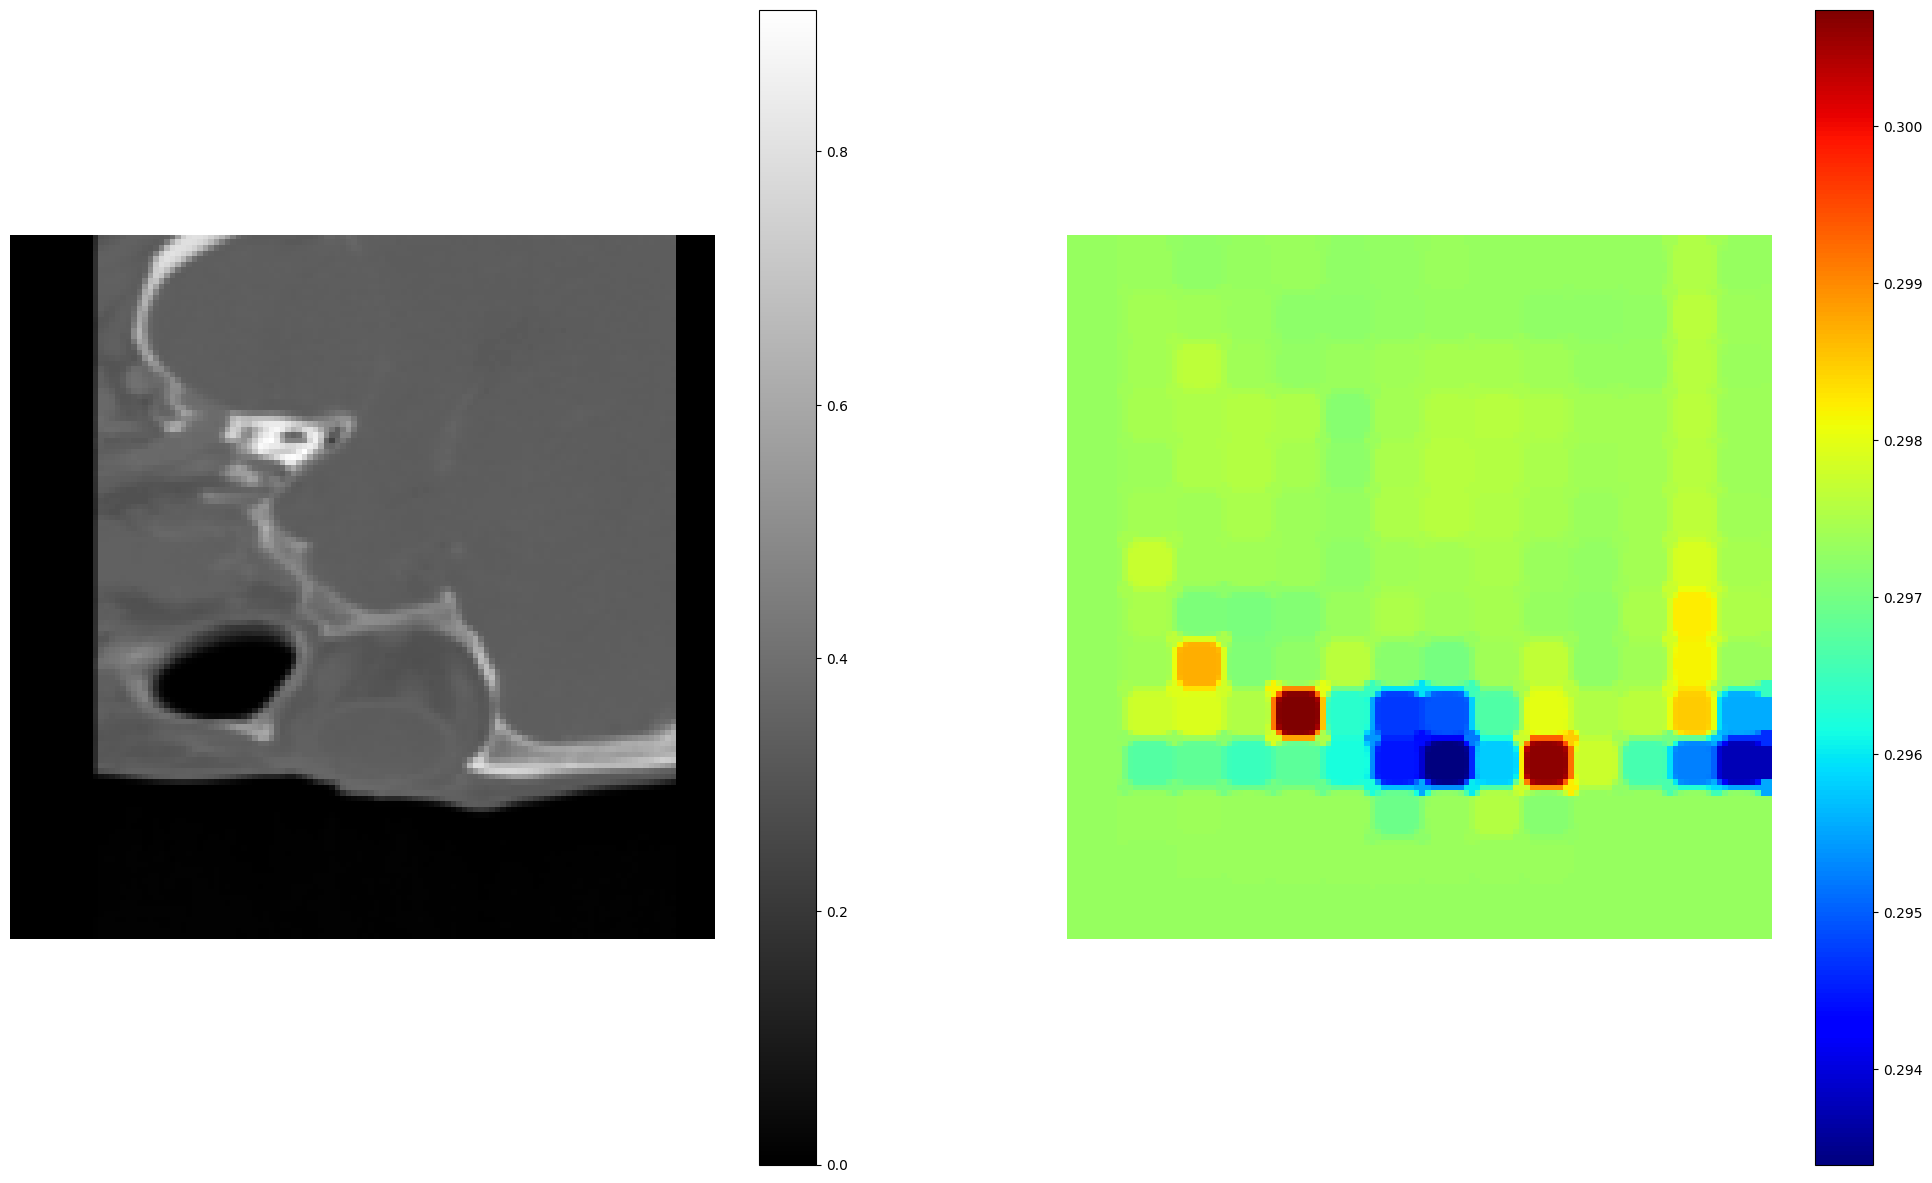

In [20]:
# Get a random image and its corresponding label
img, label = get_next_im()

# Get the occlusion sensitivity map
occ_sens = monai.visualize.OcclusionSensitivity(nn_module=model, mask_size=12, n_batch=10)
# Only get a single slice to save time.
# For the other dimensions (channel, width, height), use
# -1 to use 0 and img.shape[x]-1 for min and max, respectively


depth_slice = img.shape[2] // 3
occ_sens_b_box = [depth_slice - 1, depth_slice, -1, -1, -1, -1]

occ_result, _ = occ_sens(x=img, b_box=occ_sens_b_box)
occ_result = occ_result[0, label.argmax().item()][None]

fig, axes = plt.subplots(1, 2, figsize=(25, 15), facecolor="white")

for i, im in enumerate([img[:, :, depth_slice, ...], occ_result]):
    cmap = "gray" if i == 0 else "jet"
    ax = axes[i]
    im_show = ax.imshow(np.squeeze(im[0][0].detach().cpu()), cmap=cmap)
    ax.axis("off")
    fig.colorbar(im_show, ax=ax)

## Convert ipynb to pdf

In [ ]:
!jupyter nbconvert "202311_TED_classification_v1.ipynb" --to PDF "202311_TED_classification_v1.pdf"